In [1]:
#!/usr/bin/env python
import sys
from pathlib import Path

from ase.io import read, write
from ase.spacegroup import get_spacegroup

def isequal_species(species1:list[str], species2:list[str]):
    """判断species1中全部元素是否都在species2中"""
    if len(species1) == len(species2):
        for spe in species1:
            if spe not in species2:
                return False
        else:
            return True

# species = sys.argv[1:]
species = ['Ce', 'Al']
# 获取当前目录下的所有文件
current_dir = Path('../test')

# 筛选出以 .vasp 结尾的文件名
vasp_files = [file for file  in current_dir.iterdir() if file.suffix == '.vasp']

i = 0
for vf in vasp_files:
    at = read(vf)
    if isequal_species(species1=species, species2=set(at.symbols)):
        i += 1
        newname = current_dir.joinpath(str(i)+'.'+f'{at.symbols}' + '.vasp')
        write(filename=newname, images=at, format='vasp')
    else:
        print(False)


## 写lammps文件结构

In [3]:
from ase.io import read, write
from ase.io.lammpsdata import write_lammps_data
from ase import Atoms
import numpy as np

def remove_hydrogen_and_convert(input_file, output_file, element_order):
    """
    读取 LAMMPS 轨迹文件，删除氢原子，按照指定顺序重新排列元素，写入 LAMMPS 格式文件。
    
    Args:
        input_file (str): 输入的 LAMMPS trajectory 文件名。
        output_file (str): 输出的 LAMMPS 格式文件名。
        element_order (list): 指定的元素排列顺序，例如 ['C', 'O', 'H', 'N']。
    """
    # 读取 LAMMPS 轨迹
    frames = read(input_file, format='lammps-dump-text', index=':')
    print(f"读取到 {len(frames)} 帧轨迹")

    # 处理每一帧，删除氢原子并按照指定顺序排列元素
    processed_frames = []
    for i, frame in enumerate(frames):
        symbols = frame.get_chemical_symbols()
        # 只保留非氢和非铍原子
        indices_to_keep = [i for i, symbol in enumerate(symbols) if symbol not in ['H', 'Be']]
        
        # 删除氢和铍原子
        new_frame = frame[indices_to_keep]
        
        # 按照指定的元素顺序排序
        element_to_index = {element: idx for idx, element in enumerate(element_order)}
        
        # 获取排序后的索引
        sorted_indices = sorted(range(len(new_frame)), key=lambda i: element_to_index[new_frame.get_chemical_symbols()[i]])
        
        # 根据指定顺序排列原子
        new_frame = new_frame[sorted_indices]

        processed_frames.append(new_frame)
        # print(f"帧 {i+1}: 保留 {len(new_frame)} 个原子")
    # print(len(processed_frames))
    # write(output_file, processed_frames, format='vasp-xdatcar')
    
    # 将结果写入 LAMMPS 格式文件
    # write(output_file, processed_frames, format='lammps-data')

    write(output_file, processed_frames, format='lammps-dump-text')
    # write_lammps_data(output_file, processed_frames[0], specorder=['La', 'Y', 'Ce', 'Th'])
    print(f"转换完成，输出文件为 {output_file}")

# 设置输入输出文件
input_file = "../test/A.lammpstrj"
output_file = "../test/new.lammpstrj"

# 定义元素排列顺序
element_order = ['La', 'Y', 'Ce', 'Th']  # 按照这个顺序排列元素

# 执行转换
remove_hydrogen_and_convert(input_file, output_file, element_order)


读取到 131 帧轨迹


ValueError: Can't write to lammps-dump-text-format

## 已知P（GPa）和V（A^3），计算其相应的能量eV

In [2]:
P = 150
V = 75.41
E=P*V*6.242e-3
E

70.60638300000001

体积：141.44 A^3, 偏导数：0.00001 GPa
体积：150.69 A^3, 偏导数：0.00001 GPa
体积：157.02 A^3, 偏导数：0.00001 GPa
体积：167.11 A^3, 偏导数：0.00001 GPa
体积：174.05 A^3, 偏导数：0.00001 GPa
体积：176.22 A^3, 偏导数：0.00001 GPa
体积：178.93 A^3, 偏导数：0.00001 GPa


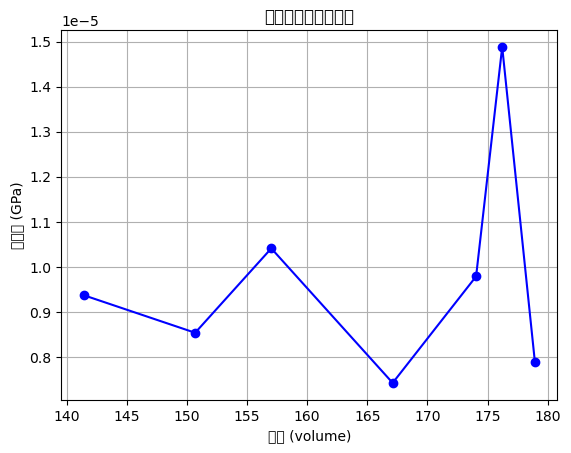

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 数据：第一列是体积（GPa），第二列是焓值（eV）
# data = np.array([
#     [134.09, -17.12125],
#     [148.8, -61.12501],
#     [152.58, -70.53088],
#     [161.46, -90.11916],
#     [172.76, -111.00351],
#     [175.33, -116.70158],
#     [177.1, -122.58889],
#     [180.76, -128.36786]
# ])

data = np.array([
[134.09, 0.22802],
[148.8,	 0.20594],
[152.58, 0.20077],
[161.46, 0.18596],
[172.76, 0.17252],
[175.33, 0.16849],
[177.1,	 0.16427],
[180.76, 0.15964],
])

# 体积和焓值
volume = data[:, 0]
enthalpy = data[:, 1]

# 数值微分，使用前向差分
dV = np.diff(volume)
dH = np.diff(enthalpy)

# 偏导数（dH/dV）
derivative = - dH / dV * 6.242e-3

# 显示计算结果
for i in range(len(derivative)):
    print(f"体积：{(volume[i] + volume[i+1]) / 2:.2f} A^3, 偏导数：{derivative[i]:.5f} GPa")

# 可视化偏导数
plt.plot((volume[:-1] + volume[1:]) / 2, derivative, marker='o', linestyle='-', color='b')
plt.xlabel('体积 (volume)')
plt.ylabel('偏导数 (GPa)')
plt.title('焓值对体积的偏导数')
plt.grid(True)
plt.show()
